In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

!pip install openpyxl

In [3]:
data = pd.read_excel("data/ESG_raw_data_07_02.xlsx")

In [4]:
variables = ["scope_1", "scope_2", "scope_3", "waste_production",
             "waste_recycling", "water_consumption", "water_withdrawal",
             "energy_consumption", "hours_of_training", "independent_board_members_percentage",
             "legal_costs_paid_for_controversies", "ceo_compensation", "gender_pay_gap"]

variables_env =  ["scope_1", "scope_2", "scope_3", "waste_production",
             "waste_recycling", "water_consumption", "water_withdrawal",
             "energy_consumption"]

In [9]:
def isnan(num) :
    if num != num : 
        return True
    else :
        return False

def isntnan(num) :
    return bool(1 - int(isnan(num)))

def nanin(col) :
    for x in col :
        if isnan(x) :
            return True
    return False

# Un peu de Statdesc pour commencer

# Manque d'information et industries polluantes

On étudie la relation entre le manque d'information sur le "gender_pay_gap" et le fait qu'une industrie soit particulièrement polluante ou non, i.e si son "scope_1" moyen est élevé.

Pour commencer, je vais "normaliser" toutes les variables quantitatives par le nombre d'employés dans l'entreprise, afin que ces grandeurs puissent être comparées. Il est important de noter que je ne renomme pas ces variables.

In [6]:
data["scope_1"].head(5)

0    47430.0
1    52730.0
2    57440.0
3    49100.0
4    44700.0
Name: scope_1, dtype: float64

In [7]:
df = data
for x in variables_env :
    df[x] = df[x]/df['employees']

In [8]:
df["scope_1"].head(5)

0    0.322653
1    0.384891
2    0.435152
3    0.735030
4    0.565823
Name: scope_1, dtype: float64

On calcule alors les moyennes de données manquantes pour le "gender_pay_gap" et pour le "scope_1" par industrie.

In [10]:
missing_mean = df.groupby('primary_industry')['gender_pay_gap'].apply(lambda x: x.isnull().mean())
scope_1_mean = df.groupby('primary_industry')['scope_1'].mean()

In [25]:
scope_1_mean = scope_1_mean.dropna()
print(scope_1_mean.sort_values())

primary_industry
Insurance Brokers                                     0.123478
Diversified Capital Markets                           0.210797
Systems Software                                      0.220121
Asset Management and Custody Banks                    0.253842
Apparel Retail                                        0.377051
                                                      ...     
Independent Power Producers and Energy Traders     5056.270213
Gold                                               7292.832339
Marine                                            12240.532480
Oil and Gas Storage and Transportation            13145.662761
Electric Utilities                                15354.066107
Name: scope_1, Length: 151, dtype: float64


Et on plot tout ça.

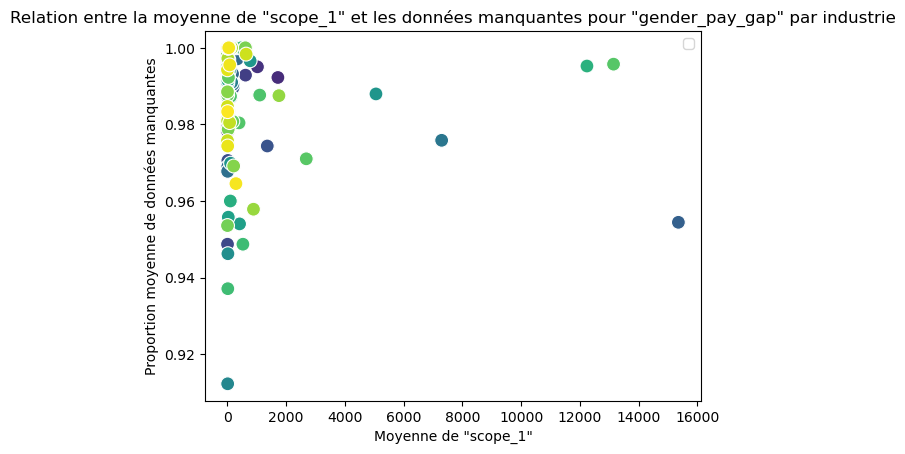

In [26]:
sns.scatterplot(x = scope_1_mean, y = missing_mean, hue = missing_mean.index, palette = 'viridis', s = 100)
plt.xlabel('Moyenne de "scope_1"')
plt.ylabel('Proportion moyenne de données manquantes')
plt.title('Relation entre la moyenne de "scope_1" et les données manquantes pour "gender_pay_gap" par industrie')
plt.legend('')
#plt.ylim((-10, 2000))
plt.show()

On peut alors effectuer des régressions, on va contrôler sur la région et sur l'année. On en effectue deux : une simple et une avec le "scope_1" en log. Ces régressions sont faites sur chaque entreprise, avec en $Y$ une variable binaire : le fait d'avoir ou non la donnée sur le "gender_pay_gap" et en co-variables : le "scope_1" de l'entreprise (normalisé par son nombre d'employés), la région, l'année. 

In [39]:
df2 = df

df2['missing'] = df2['gender_pay_gap'].isnull().astype(float)
df2 = df2.dropna(subset=['scope_1'])
df2['scope_1_log'] = np.log(df2['scope_1'])

# Régressions linéaires avec contrôle sur la région et l'année
X1 = df2[['scope_1', 'region', 'year']]
X1 = pd.get_dummies(X1, columns=['region', 'year'], drop_first=True, dtype=float)
X1 = sm.add_constant(X1)

X2 = df2[['scope_1_log', 'region', 'year']]
X2 = pd.get_dummies(X2, columns=['region', 'year'], drop_first=True, dtype=float)
X2 = sm.add_constant(X2)

y1 = df2['missing']

model1 = sm.OLS(y1, X1).fit()

# Pour le log, on doit filtrer les valeurs Nan car il y avait des "scope_1" égaux à 0
mask = ~X2.isin([np.nan, np.inf, -np.inf]).any(axis=1)
X2 = X2[mask]
y2 = df2['missing'][mask]
model2 = sm.OLS(y2, X2).fit()

print(model1.summary())
print(model2.summary())

/opt/mamba/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2885/3473654432.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['scope_1_log'] = np.log(df2['scope_1'])


                            OLS Regression Results                            
Dep. Variable:                missing   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     93.20
Date:                Sun, 11 Feb 2024   Prob (F-statistic):          1.56e-132
Time:                        14:43:16   Log-Likelihood:                 3354.3
No. Observations:               10705   AIC:                            -6693.
Df Residuals:                   10697   BIC:                            -6634.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons